In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stumpy
from matplotlib.patches import Rectangle

import numpy as np

In [2]:
fixations = pd.read_parquet("../data/processed/fixations-fixed.parq")

In [6]:
source_file = 'rectangle-with-bug.cpp'
fixations_for_snippet=fixations.query(f"gaze_target == '{source_file}'")

In [9]:
fixations_for_snippet.to_numpy()

array([[0.0, 17.30207625, 16.703319166666667, ..., 170.0, 40, 7],
       [1.0, 17.168024615384613, 16.60752, ..., 107.0, 41, 4],
       [2.0, 16.856500526315788, 15.978246842105264, ..., 144.0, 41, 27],
       ...,
       [266.0, 18.740836470588235, 16.525936470588235, ..., 138.0, 31, 5],
       [270.0, 19.419062285714286, 18.762782571428573, ..., 301.0, 29, 4],
       [274.0, 18.778006363636365, 19.10264878787879, ..., 273.0, 11, 4]],
      dtype=object)

In [152]:
def dedup_consecutive(x: list):
    if not x:
        return []
    
    d = [x[0]] 
    for i, item in enumerate(x[1:], start=1):
        if item != x[i - 1]:
            d.append(item)
    return d

fixation_sequences = fixations_for_snippet.groupby(level=[0, 1])[
    ["source_file_line"]
].apply(lambda x: x["source_file_line"].tolist()).apply(dedup_consecutive)



In [153]:
# fixation_sequences

In [154]:
fixation_sequences

pid   tid
p100  t2     [40, 41, 40, 35, 7, 5, 2, 20, 5, 4, 24, 28, 0,...
p101  t3     [38, 35, 36, 37, 36, 35, 36, 35, 36, 37, 36, 3...
p102  t2     [40, 38, 40, 5, 40, 36, 40, 36, 35, 5, 13, 15,...
p103  t4     [41, 35, 32, 41, 33, 23, 37, 35, 37, 40, 9, 0,...
p105  t1     [31, 28, 23, 29, 35, 36, 40, 29, 28, 5, 7, 4, ...
p106  t2     [35, 20, 18, 20, 15, 5, 2, 4, 5, 7, 5, 7, 4, 5...
p107  t1     [38, 40, 36, 35, 36, 0, 5, 40, 15, 20, 13, 7, ...
p83   t3     [21, 16, 31, 19, 37, 21, 16, 30, 36, 42, 40, 3...
p84   t1     [24, 35, 30, 28, 20, 23, 37, 38, 40, 37, 40, 5...
p85   t2     [18, 41, 40, 35, 37, 41, 42, 40, 41, 10, 13, 1...
p86   t3     [20, 18, 23, 25, 40, 18, 35, 28, 18, 15, 7, 5,...
p87   t5               [13, 20, 40, 20, 10, 15, 5, 20, 31, 38]
p88   t1     [18, 4, 2, 7, 5, 8, 5, 8, 7, 9, 7, 9, 8, 9, 7,...
p89   t2     [5, 2, 5, 2, 0, 3, 2, 4, 0, 5, 2, 5, 7, 8, 5, ...
p90   t4     [15, 20, 15, 20, 21, 14, 35, 29, 35, 36, 28, 3...
p91   t1     [15, 5, 7, 4, 3, 8, 9, 8, 9, 8, 

In [155]:



def combine_sequences(sequences):
    items = []
    for sequence in sequences:
        items.extend(sequence)
        items.append(np.nan)
    return np.array(items)


The motif is located at index 2942
The nearest neighbor is located at index 1506


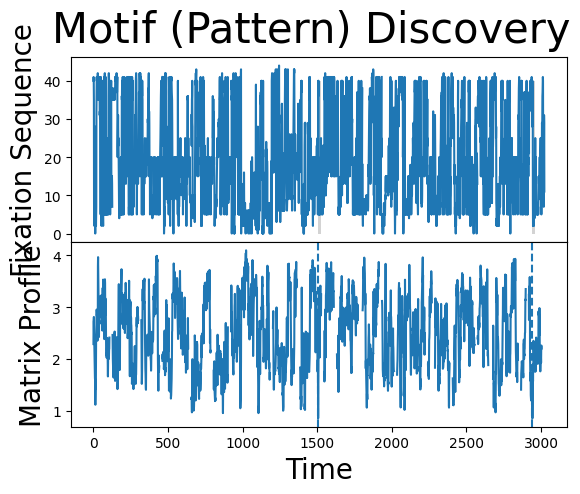

In [156]:

combined = combine_sequences(fixation_sequences)

m = 20
mp = stumpy.stump(combined, m=m)
motif_idx = np.argsort(mp[:, 0])[0]
print(f"The motif is located at index {motif_idx}")

nearest_neighbor_idx = mp[motif_idx, 1]
def draw_motif_discovery_graph(sequence, motif_idx, nearest_neighbor_idx):
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
    plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

    axs[0].plot(sequence)
    axs[0].set_ylabel('Fixation Sequence', fontsize='20')
    rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[1].set_xlabel('Time', fontsize ='20')
    axs[1].set_ylabel('Matrix Profile', fontsize='20')
    axs[1].axvline(x=motif_idx, linestyle="dashed")
    axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
    axs[1].plot(mp[:, 0])
    plt.show()
    
print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

draw_motif_discovery_graph(combined, motif_idx, nearest_neighbor_idx)




In [157]:
mp.shape

(3005, 4)

In [158]:
mp[:, 0].shape

(3005,)

```
When k = 1 (default), 
    * the first column consists of the matrix profile, 
    * the second column consists of the matrix profile indices, 
    * the third column consists of the left matrix profile indices, 
    * the fourth column consists of the right matrix profile indices. 

However, when k > 1, the output array will contain exactly 2 * k + 2 columns. 
    * The first k columns (i.e., out[:, :k]) consists of the top-k matrix profile, 
    * the next set of k columns (i.e., out[:, k:2k]) consists of the corresponding top-k matrix profile indices,
    * the last two columns (i.e., out[:, 2k] and out[:, 2k+1] or, equivalently, out[:, -2] and out[:, -1]) correspond to the top-1 left matrix profile indices and the top-1 right matrix profile indices, respectively.
```

In [159]:
mp[:, 0]

array([2.2877941955080883, 2.7241153394863544, 2.7491462950136256, ...,
       2.259607668979982, 2.199860933611215, inf], dtype=object)

In [160]:
mp[:, 1]

array([1990, 662, 663, ..., 1843, 2461, -1], dtype=object)

In [161]:
distances = mp[:, 0].astype(float)
sorted_indices = np.argsort(distances)
printed = 0
for pattern_index in sorted_indices[-500:]:
    if not np.isinf(distances[pattern_index]) and printed < 10:
        printed += 1
        print(f"Pattern at index {pattern_index} with distance {distances[pattern_index]}")

Pattern at index 1355 with distance 3.727301877265405
Pattern at index 1025 with distance 3.728902975932466
Pattern at index 2118 with distance 3.729443981092494
Pattern at index 1565 with distance 3.7302380613336252
Pattern at index 2639 with distance 3.7310650984186657
Pattern at index 1473 with distance 3.7315579475266616
Pattern at index 188 with distance 3.7340121626910467
Pattern at index 1067 with distance 3.736643961634386
Pattern at index 1024 with distance 3.7426174571457382
Pattern at index 1818 with distance 3.744472045878511


In [162]:
fixation_boundaries = (fixation_sequences.apply(len).cumsum() + 1).shift(fill_value=0).astype(int)

In [165]:
# np.searchsorted(fixation_boundaries, 1752)-1
import dataclasses
import numpy.typing as npt


@dataclasses.dataclass(kw_only=True)
class MatrixProfile:
    sequence: npt.ArrayLike
    m: int
    matrix_profile: npt.NDArray
    k: int = 1

    @staticmethod
    def create(sequence: npt.ArrayLike, m: int, k: int = 1, **kwargs):
        mp = stumpy.stump(sequence, m,**kwargs)
        return MatrixProfile(sequence=sequence, m=m, matrix_profile=mp)


@dataclasses.dataclass
class FixationSequenceMatrixProfile:
    matrix_profile: MatrixProfile
    fixation_sequence: npt.ArrayLike
    fixation_boundaries: npt.ArrayLike
    source: str

    @staticmethod
    def create(source:str, fixation_sequences: pd.Series, m: int, k: int = 1, **kwargs):
        sequence = combine_sequences(fixation_sequences)
        matrix_profile = MatrixProfile.create(sequence, m, k, **kwargs)
        fixation_boundaries = (fixation_sequences.apply(len).cumsum() + 1).shift(
            fill_value=0
        )
        return FixationSequenceMatrixProfile(
            source=source,
            matrix_profile=matrix_profile,
            fixation_sequence=sequence,
            fixation_boundaries=fixation_boundaries,
        )
    
    def topk_motif_idx(self, k: int = 10):
        distances = self.matrix_profile.matrix_profile[:, 0].astype(float)
        sorted_indices = np.argsort(distances)
        motifs = []
        for pattern_index in reversed(sorted_indices):
            if not np.isinf(distances[pattern_index]):
                motifs.append(pattern_index)
            if len(motifs) == k:
                break
            
        return motifs

    def sorted_motif_indices(self):
        distances = self.matrix_profile.matrix_profile[:, 0].astype(float)
        sorted_indices = np.argsort(distances)

        for pattern_index in reversed(sorted_indices):
            if not np.isinf(distances[pattern_index]):
                yield pattern_index
    
    def sorted_motifs(self):
        for motif_idx in self.sorted_motif_indices():
            yield self.matrix_profile.sequence[motif_idx: motif_idx + self.matrix_profile.m]
            
     
    def show_top_k_motifs(self, k: int = 10):
        motifs = self.topk_motif_idx(k)

        for motif_idx in motifs:
            self.show_motif_at(motif_idx)
    
    def show_motif_at(self, motif_idx: int):
        source_lines = self.source.splitlines()
        sequence = self.matrix_profile.sequence[motif_idx: motif_idx + self.matrix_profile.m]
        for line_idx in sequence:
            print(f"{line_idx:03}: {source_lines[int(line_idx)]}") 
    

from analysis.data import load_file_contents

source = load_file_contents("../data/raw/snippets/rectangle-with-bug.cpp")
source_lines = source.splitlines()
matrix_profile = FixationSequenceMatrixProfile.create(source,fixation_sequences, m=10)
# matrix_profile.show_top_k_motifs(20)

i = 0
for motif in  matrix_profile.sorted_motifs():
    if len(set(motif)) > 1:
        print("-" * 20 + f"{i}" + "-" * 20)
        for line in motif:
            print(f"{line:03}: {source_lines[int(line)]}")
        # print('-' * 20)
        i += 1
    if i == 10:
        break


--------------------0--------------------
11.0:     }
4.0: public:
16.0:     }
4.0: public:
6.0:     {
8.0:         this->y1 = y1;
6.0:     {
8.0:         this->y1 = y1;
6.0:     {
4.0: public:
--------------------1--------------------
4.0: public:
8.0:         this->y1 = y1;
0.0: #include <iostream>
6.0:     {
4.0: public:
2.0: class Rectangle
4.0: public:
0.0: #include <iostream>
6.0:     {
4.0: public:
--------------------2--------------------
10.0:         this->y2 = y2;
15.0:         return this->x2 - this->y1;
10.0:         this->y2 = y2;
15.0:         return this->x2 - this->y1;
13.0:     int width()
10.0:         this->y2 = y2;
15.0:         return this->x2 - this->y1;
10.0:         this->y2 = y2;
9.0:         this->x2 = x2;
10.0:         this->y2 = y2;
--------------------3--------------------
41.0:     std::cout << rect1.area() << std::endl;
15.0:         return this->x2 - this->y1;
40.0:     Rectangle rect1(0, 0, 10, 10);
20.0:         return this->x2 - this->y2;
15.0:      

5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
--
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, int y1, int x2, int y2)
5.0:     Rectangle(int x1, i

In [113]:
fixation_boundaries.iloc[6]

1584

In [109]:
fixation_boundaries

pid   tid
p100  t2        0
p101  t3      207
p102  t2      540
p103  t4      795
p105  t1     1114
p106  t2     1365
p107  t1     1584
p83   t3     2045
p84   t1     2365
p85   t2     2615
p86   t3     2724
p87   t5     3048
p88   t1     3065
p89   t2     3289
p90   t4     3463
p91   t1     3789
p92   t3     3846
p93   t1     4067
p94   t4     4360
p95   t2     4555
p97   t3     4569
p98   t4     5068
p99   t3     5158
dtype: int64

In [102]:
fixation_sequences.apply(len).sum()

5357

pid   tid
p100  t2        0
p101  t3      207
p102  t2      540
p103  t4      795
p105  t1     1114
p106  t2     1365
p107  t1     1584
p83   t3     2045
p84   t1     2365
p85   t2     2615
p86   t3     2724
p87   t5     3048
p88   t1     3065
p89   t2     3289
p90   t4     3463
p91   t1     3789
p92   t3     3846
p93   t1     4067
p94   t4     4360
p95   t2     4555
p97   t3     4569
p98   t4     5068
p99   t3     5158
dtype: int64

23

In [82]:
sorted_indices

array([2934, 4619, 5026, ..., 2042, 2040, 5360])

In [70]:
distances.astype(float)

array([2.17923568, 2.28815666, 2.53654772, ..., 1.54215562, 1.54315503,
              inf])